# Cars dimensions

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
# Loading dataset
df = pd.read_csv("CQA_Premium.csv")
sizes = df[['model_length_mm', 'model_width_mm']].dropna(0, 'any')
print("shape:", sizes.shape)

shape: (54808, 2)


## Primary plot

Here we plot dots with cars length as abcissas and cars width as ordinates. Then we arbitrarily select a default validation zone, along with two 'grey zones' within the default zone, where there are no dots.

In [3]:
# Plotting unique pairs of (length, width)
def rect_range(rangex, rangey):
    """ Creates a list of abcissas and ordinates,
        to plot a rectangle.
    """
    minx, maxx = rangex
    miny, maxy = rangey
    return [minx, maxx, maxx, minx, minx],\
           [miny, miny, maxy, maxy, miny]

def uniqueness(x, y):
    assert(len(x) == len(y))
    occurences = {}
    for pair in zip(x, y):
        if pair not in occurences.keys():
            occurences[pair] = 0
        occurences[pair] += 1
    pair_set = occurences.keys()
    return [p for p in pair_set if occurences[p] == 1],\
           [p for p in pair_set if occurences[p] > 1]
    
unique, non_unique = uniqueness(sizes['model_length_mm'][::10],
                                sizes['model_width_mm'][::10])


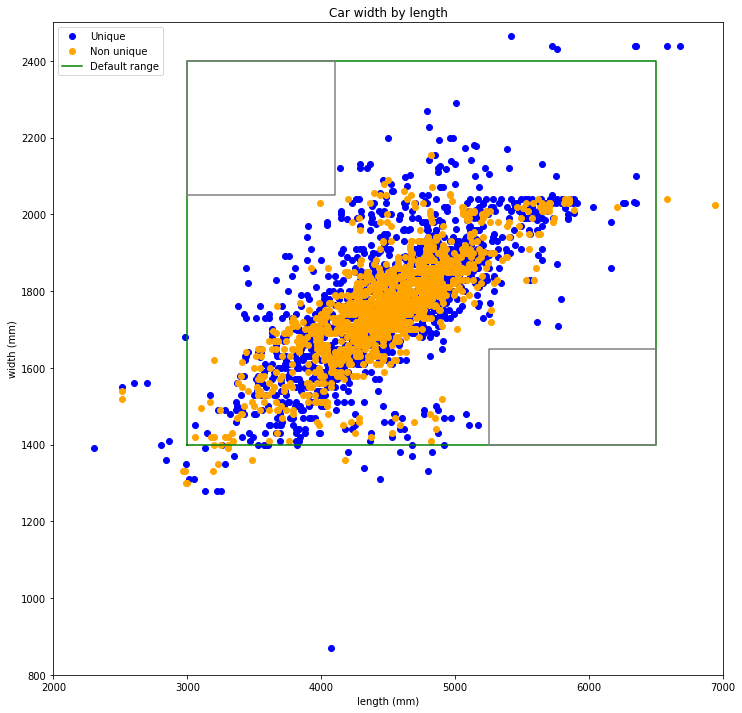

In [4]:
green_zone = rect_range((3000, 6500), (1400, 2400))
grey_zone_a = rect_range((3000, 4100), (2050, 2400))
grey_zone_b = rect_range((5250, 6500), (1400, 1650))

plt.figure(figsize=(12, 12))

plt.plot([p[0] for p in unique], [p[1] for p in unique],
         'o', label='Unique', c='blue')
plt.plot([p[0] for p in non_unique], [p[1] for p in non_unique],
         'o', label='Non unique', c='orange')
plt.plot(green_zone[0], green_zone[1],
         label='Default range', c='green')
plt.plot(grey_zone_a[0], grey_zone_a[1],
         c='grey')
plt.plot(grey_zone_b[0], grey_zone_b[1],
         c='grey')

plt.title("Car width by length")
plt.xlabel("length (mm)")
plt.ylabel("width (mm)")
plt.xlim(2000, 7000)
plt.ylim(800, 2500)
plt.legend(loc='best')
plt.show()

## Anomaly generation

Here we generate wrong dots within the grey zone and outside the default zone.


In [5]:
def is_in(dot, zone):
    x, y = dot
    minx, maxx = zone[0][:2]
    miny, maxy = zone[1][1:3]
    if x < minx or x > maxx or y < miny or y > maxy:
        return False
    return True

def generate_dots(zone, n, deadzone=None):
    minx, maxx = zone[0][:2]
    miny, maxy = zone[1][1:3]
    dots = []
    while len(dots) < n:
        dot = rd.randint(minx, maxx), rd.randint(miny, maxy)
        if deadzone is None or not is_in(dot, deadzone):
            dots.append(dot)
    return dots

display_zone = rect_range((2000, 7000), (800, 2500))

wrong_dots = generate_dots(grey_zone_a, 100)\
            + generate_dots(grey_zone_b, 100)\
            + generate_dots(display_zone, 500, green_zone)

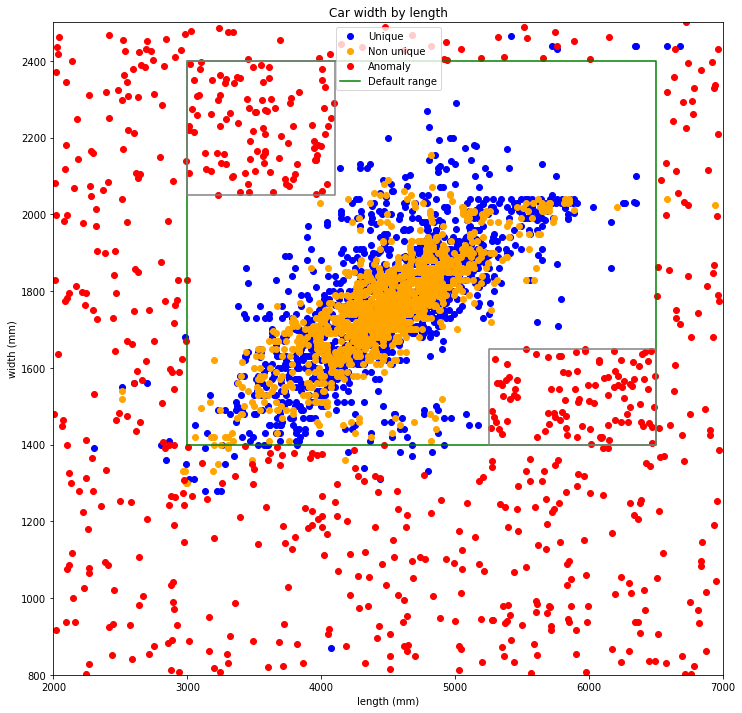

In [6]:
plt.figure(figsize=(12, 12))

plt.plot([p[0] for p in unique], [p[1] for p in unique],
         'o', label='Unique', c='blue')
plt.plot([p[0] for p in non_unique], [p[1] for p in non_unique],
         'o', label='Non unique', c='orange')
plt.plot([p[0] for p in wrong_dots], [p[1] for p in wrong_dots],
         'o', label='Anomaly', c='red')
plt.plot(green_zone[0], green_zone[1],
         label='Default range', c='green')
plt.plot(grey_zone_a[0], grey_zone_a[1],
         c='grey')
plt.plot(grey_zone_b[0], grey_zone_b[1],
         c='grey')

plt.title("Car width by length")
plt.xlabel("length (mm)")
plt.xlim(2000, 7000)
plt.ylim(800, 2500)
plt.ylabel("width (mm)")
plt.legend(loc='best')
plt.show()

In [7]:
# Building new dataset
dfList = [[dot[0], dot[1], True, 1] for dot in unique]
dfList += [[dot[0], dot[1], False, 1] for dot in non_unique]
dfList += [[dot[0], dot[1], False, 0] for dot in wrong_dots]
nRows = len(dfList)
dataset = pd.DataFrame(dfList,
                       columns=["length", "width", "unique", "isValid"])\
            .sample(frac=1)

training_set = dataset.iloc[:nRows // 2, :]
test_set = dataset.iloc[nRows // 2:, :]

print("training set shape:", training_set.shape)
print("test set shape:    ", test_set.shape)

test_Valid=test_set.loc[test_set["isValid"].values[:]==1]
test_Valid2=test_set.loc[test_set["isValid"].values[:]==0]

print(test_Valid.shape)
print(test_Valid2.shape)

training set shape: (1593, 4)
test set shape:     (1594, 4)
(1230, 4)
(364, 4)


## Classifier and decision boundaries

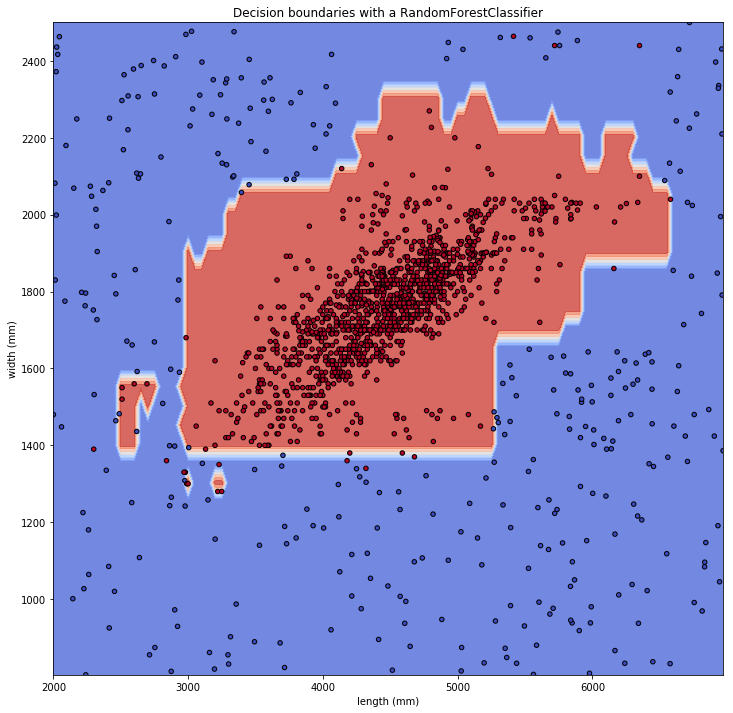

In [8]:
def make_meshgrid(x, y, h=50):
    x_min, x_max = x.min() - h, x.max() + h
    y_min, y_max = y.min() - h, y.max() + h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_boundaries(clf, title):
    X = training_set.loc[:, ["length", "width"]].values[:]
    y = training_set["isValid"].values[:]

    clf.fit(X, y)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

    ax.set_xlabel("length (mm)")
    ax.set_ylabel("width (mm)")

    ax.set_title("Decision boundaries with a " + title)

    plt.xlim(X0.min(), X0.max())
    plt.ylim(X1.min(), X1.max())
    
    plt.show()
    
# plot_decision_boundaries(tree.DecisionTreeClassifier(),
#                          "Decision Tree Classifier")
plot_decision_boundaries(ensemble.RandomForestClassifier(),
                         "RandomForestClassifier")

In [9]:
# Test score
clf = ensemble.RandomForestClassifier()
clf.fit(training_set.loc[:, ["length", "width"]], training_set["isValid"])
score = clf.score(test_set.loc[:, ["length", "width"]], test_set["isValid"])
print("test score:", score)

test score: 0.9774153074027604


# Neural Network

In [10]:
X_train=training_set.loc[:, ["length", "width"]].values[:] 
X_test=test_set.loc[:, ["length", "width"]]
y_train=training_set["isValid"].values[:] 
y_test=test_set["isValid"]

scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train,y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))      #Mean accuracy of self.predict(X) wrt. y.
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 0.983051
Test set score: 0.973651


In [11]:
predictions = mlp.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
#extraction of the MLP weights and biases after training the model

print("Extraction of the MLP weights and biases after training the model:")
print(len(mlp.coefs_))  #The ith element in the list represents the weight matrix corresponding to layer i
print(len(mlp.coefs_[0])) 
print(len(mlp.intercepts_[0]))  #a list of bias vectors

Confusion Matrix:
[[ 336   28]
 [  14 1216]]
             precision    recall  f1-score   support

          0       0.96      0.92      0.94       364
          1       0.98      0.99      0.98      1230

avg / total       0.97      0.97      0.97      1594

Extraction of the MLP weights and biases after training the model:
4
2
30


# Adaboost

In [12]:
X_train=training_set.loc[:, ["length", "width"]].values[:] 
X_test=test_set.loc[:, ["length", "width"]]
y_train=training_set["isValid"].values[:] 
y_test=test_set["isValid"]
Score= np.zeros((300,1))

for i in range(1,300):
    # Create adaboost-decision tree classifer object
    abc = AdaBoostClassifier(n_estimators=i,
                         learning_rate=1,
                         random_state=0)
    # Fit
    abc.fit(X_train, y_train)
    # Predict
    y_pred = abc.predict(X_test)

    # Accuracy
    Score[i]= accuracy_score(y_pred, y_test)

plt.plot([p for p in range(1,301)],[q for q in Score])
plt.ylim(0.75, 1)
plt.show()

KeyboardInterrupt: 

In [ ]:
print("Accuracy=" +str(max(Score))+ "for n_estimators=" + str(np.argmax(Score)))

print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred))